In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import xavierUtils as xu
from matplotlib.ticker import MaxNLocator
from matplotlib import lines
import matplotlib.colors as colors 
from matplotlib.patches import Patch
import datetime as dt
from IPython.display import display
%autosave 1000000

Autosaving every 1000000 seconds


### Funções 

### Carrega dados

In [4]:
# Dados de votações:
initial_date = '2019-02-01'
final_date   = '2019-05-10'
query = 'SELECT * FROM `gabinete-compartilhado.analise_congresso_votacoes.senado_orientacao_senadores_tab` \
WHERE data_displaced BETWEEN DATE \'{}\' AND DATE \'{}\''.format(initial_date, final_date)

r = pd.read_gbq(query, project_id='gabinete-compartilhado', 
                dialect='standard',
                private_key='../../keys-configs/gabinete-compartilhado-42394b04e230.json')

In [5]:
def countDuplicates(df):
    ndup = len(df.loc[df.duplicated()])
    return len(df), ndup, float()/len(df)

In [6]:
xu.unique(r.columns)

17: DataSessao | DescricaoResultado | DescricaoVoto | ano | apoio | data_displaced | id_lider_gov | id_senador | legislatura | nome_senador | num_votacao | partido_senador | tipoMateria | votacaoSecreta | voto_bool | voto_bool_lider_gov | voto_lider_gov


In [7]:
# Preenche partidos faltantes com 'sem partido':
# Reseta indice:
# Remove votações duplicadas:
v = r.reset_index(drop=True)
v = v.drop_duplicates()


v['partido_senador'] = v[['partido_senador']].fillna('S.PART.')['partido_senador']
print len(r), len(v), float(len(v))/len(r)
print countDuplicates(v)

5440 5440 1.0
(5440, 0, 0.0)


In [8]:
xu.unique(v.columns)

17: DataSessao | DescricaoResultado | DescricaoVoto | ano | apoio | data_displaced | id_lider_gov | id_senador | legislatura | nome_senador | num_votacao | partido_senador | tipoMateria | votacaoSecreta | voto_bool | voto_bool_lider_gov | voto_lider_gov


### Exploração

In [9]:
r.loc[(r.partido_senador.isnull())&(r.legislatura==56)][['id_senador','nome_senador']].drop_duplicates()

,id_senador,nome_senador


In [10]:
xu.checkMissing(r)

Colunas com valores faltantes:
             coluna    N      %
10  partido_senador  820  15.07


In [11]:
r.loc[r.partido_senador=='S.PART.'][['legislatura','nome_senador','partido_senador']].drop_duplicates()

,legislatura,nome_senador,partido_senador
2365,52,Augusto Botelho,S.PART.
2368,52,Demóstenes Torres,S.PART.
2476,52,Delcídio do Amaral,S.PART.
2876,53,Augusto Botelho,S.PART.
2878,53,Demóstenes Torres,S.PART.
2934,53,Delcídio do Amaral,S.PART.
3285,54,Delcídio do Amaral,S.PART.
3343,54,Walter Pinheiro,S.PART.
3350,54,Demóstenes Torres,S.PART.
3920,55,Walter Pinheiro,S.PART.


In [12]:
xu.mapUnique(v)


num_votacao: 94 unique values.
(sample) 154,  155,  156,  163,  167,  734,  748,  752,  1112,  1625,  1637,  2159,  2171,  2172,  2175,  2702,  2704,  3265,  3271,  3276

legislatura: 7 unique values.
50,  51,  52,  53,  54,  55,  56

ano: 7 unique values.
1995,  1999,  2003,  2007,  2011,  2015,  2019

data_displaced: 34 unique values.
(sample) 2019-02-22T00:00:00.000000000,  2019-02-28T00:00:00.000000000,  2019-03-03T00:00:00.000000000,  2019-03-04T00:00:00.000000000,  2019-03-09T00:00:00.000000000,  2019-03-10T00:00:00.000000000,  2019-03-12T00:00:00.000000000,  2019-03-19T00:00:00.000000000,  2019-03-24T00:00:00.000000000,  2019-03-25T00:00:00.000000000,  2019-03-27T00:00:00.000000000,  2019-04-02T00:00:00.000000000,  2019-04-09T00:00:00.000000000,  2019-04-16T00:00:00.000000000,  2019-04-19T00:00:00.000000000,  2019-04-20T00:00:00.000000000,  2019-04-26T00:00:00.000000000,  2019-04-28T00:00:00.000000000,  2019-05-06T00:00:00.000000000,  2019-05-07T00:00:00.000000000

DataSessao: 

### Análise por partidos

In [13]:
# Numa dada legislatura, fração de votos de um partido que concordam com o governo:
def freqApoio(legisl,partido=None):
    if partido==None:
        s = v.loc[(v.legislatura==legisl)]['apoio']
    else:
        s = v.loc[(v.partido_senador==partido) & (v.legislatura==legisl)]['apoio']
    if len(s)==0:
        return float('NaN') 
    return xu.freq(s, 1)    

# Determina se partido apoiou governo (% de votos > limiar) em todos os governos anteriores (com exceção da Dilma 2):
# Partidos que só aparecem no governo atual são marcados com 0
def fisiologicoQ(partido, limiar):
    leg = [51,52,53,54,56]
    f   = np.array([freqApoio(l,partido) for l in leg])
    fPresente = f[np.isnan(f)==False]
    if len(fPresente)==1:
        return 0
    if len(fPresente)>1 and np.all(fPresente>limiar):
        return 1
    else:
        return -1

In [14]:
partidosAtuais = v.loc[(v.legislatura==56)&(v.partido_senador.isnull()==False)].partido_senador.unique()

In [15]:
apoioGoverno   = np.array([freqApoio(56,p) for p in partidosAtuais])

In [16]:
fisiologico    = np.array([fisiologicoQ(p,0.8) for p in partidosAtuais])

In [17]:
apoioAcredito  = xu.freq(v.loc[(v.nome_senador.isin(['Alessandro Vieira']))]['apoio'],1)
apoioByPartido = pd.DataFrame({'partido':np.append(partidosAtuais,'Acredito'), 
                               'freq':np.append(apoioGoverno,apoioAcredito), 
                               'fisio':np.append(fisiologico,False)}).sort_values('freq').reset_index()

In [18]:
xu.columns(v)

17: DataSessao | DescricaoResultado | DescricaoVoto | ano | apoio | data_displaced | id_lider_gov | id_senador | legislatura | nome_senador | num_votacao | partido_senador | tipoMateria | votacaoSecreta | voto_bool | voto_bool_lider_gov | voto_lider_gov


In [30]:
# Tamanho atual da bancada:
NsenByPartido = v.loc[v.legislatura==56].sort_values('DataSessao')\
[['id_senador', 'partido_senador']].drop_duplicates(subset='id_senador', keep='last').groupby('partido_senador').size()
NsenByPartido = NsenByPartido.append(pd.Series([1],index=['Acredito']))
NsenByPartido.name = 'nsenadores'

In [20]:
xu.unique(v.loc[v.legislatura==56].nome_senador)

81: Acir Gurgacz | Alessandro Vieira | Alvaro Dias | Angelo Coronel | Antonio Anastasia | Arolde de Oliveira | Carlos Viana | Chico Rodrigues | Cid Gomes | Ciro Nogueira | Confúcio Moura | Daniella Ribeiro | Dário Berger | Eduardo Braga | Eduardo Girão | Eduardo Gomes | Eliziane Gama | Elmano Férrer | Esperidião Amin | Fabiano Contarato | Fernando Bezerra Coelho | Fernando Collor | Flávio Arns | Flávio Bolsonaro | Humberto Costa | Irajá | Izalci Lucas | Jader Barbalho | Jaques Wagner | Jarbas Vasconcelos | Jayme Campos | Jean Paul Prates | Jorge Kajuru | Jorginho Mello | José Maranhão | José Serra | Juíza Selma | Kátia Abreu | Lasier Martins | Leila Barros | Lucas Barreto | Luis Carlos Heinze | Luiz do Carmo | Mailza Gomes | Major Olimpio | Mara Gabrilli | Marcelo Castro | Marcio Bittar | Marcos Rogério | Marcos do Val | Maria do Carmo Alves | Mecias de Jesus | Nelsinho Trad | Omar Aziz | Oriovisto Guimarães | Otto Alencar | Paulo Paim | Paulo Rocha | Plínio Valério | Randolfe Rodrigue

In [27]:
#pd.set_option('display.max_rows', 500)
#v[v.legislatura==56][['partido_senador','nome_senador']].drop_duplicates()\
#.sort_values(['partido_senador','nome_senador'])

In [28]:
NsenByPartido

Cidadania         3
DEM               5
MDB              13
PDT               4
PR                2
PRB               1
PROS              4
PSB               3
PSC               1
PSD               9
PSDB              8
PSL               4
PT                6
Podemos           8
Progressistas     6
REDE              3
S.PART.           1
Acredito          1
Name: ndeputados, dtype: int64

In [31]:
# Número médio de votos em favor do governo, por partido:
apoioEvotosByPartido = apoioByPartido.join(NsenByPartido,on='partido',how='outer')
apoioEvotosByPartido['nvotosmedio'] = apoioEvotosByPartido.freq*apoioEvotosByPartido.nsenadores
#apoioEvotosByPartido = apoioEvotosByPartido.sort_values('nvotosmedio').reset_index(drop=True)

In [32]:
# debug
xu.unique(v.columns)

17: DataSessao | DescricaoResultado | DescricaoVoto | ano | apoio | data_displaced | id_lider_gov | id_senador | legislatura | nome_senador | num_votacao | partido_senador | tipoMateria | votacaoSecreta | voto_bool | voto_bool_lider_gov | voto_lider_gov


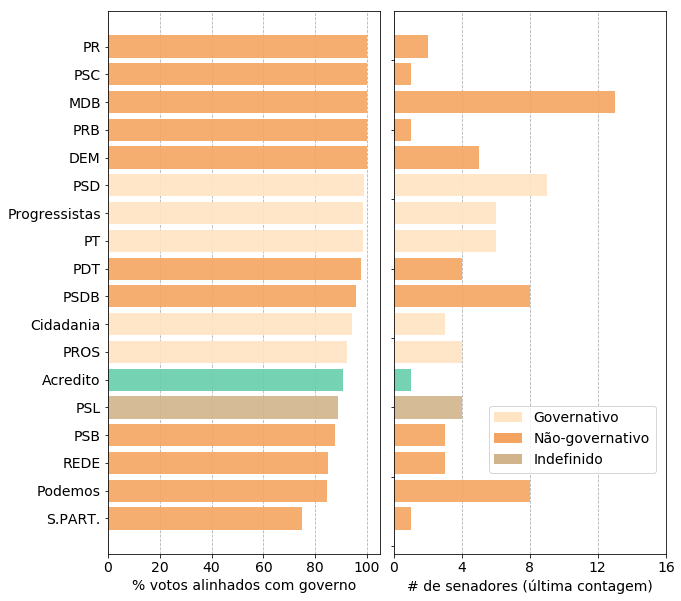

In [41]:
# Plot de todos os partidos:
def fisioC(f):
    if f==1:
        return 'bisque'
    elif f==0:
        return 'tan'
    else:
        return 'sandybrown'
cores = map(fisioC,apoioEvotosByPartido.fisio.values)
cores[apoioEvotosByPartido.loc[apoioEvotosByPartido.partido=='Acredito'].index.values[0]] = 'mediumaquamarine'
x = np.arange(1,1+len(partidosAtuais)+1)
pl.figure(figsize=(10,10))

pl.subplot(1,2,1)
pl.barh(x,100*apoioEvotosByPartido.freq.values,color=cores, zorder=2, alpha=0.9)
pl.yticks(x,apoioEvotosByPartido.partido.values)
pl.xlabel(u'% votos alinhados com governo', fontsize=14)
pl.gca().tick_params(labelsize=14)
pl.grid(axis='x',zorder=0, linestyle='--')

pl.subplot(1,2,2)
pl.barh(x,apoioEvotosByPartido.nsenadores.values,color=cores, zorder=2, alpha=0.9)
#pl.yticks(x,apoioEvotosByPartido.partido.values)
pl.gca().tick_params(labelleft=False)
pl.xlabel(u'# de senadores (última contagem)', fontsize=14)
pl.gca().tick_params(labelsize=14)
pl.grid(axis='x',zorder=0, linestyle='--')
pl.xticks(np.arange(0,20,4))

# Legenda:
legend_elements = [Patch(facecolor='bisque', label='Governativo'),
                   Patch(facecolor='sandybrown',     label=u'Não-governativo'),
                   Patch(facecolor='tan',     label=u'Indefinido')]
pl.legend(handles=legend_elements, fontsize=14, loc=(0.35,0.15))


pl.subplots_adjust(wspace=0.05)
#xu.saveFigWdate('graficos/apoio_ao_governo_partidos+tamanho.pdf')
pl.show()

In [94]:
# Histograma de votos:
#pl.hist(v[v.legislatura==51]['voto_bool'])
#pl.show()

In [95]:
# Correlação dos votos, trocando NaN por 0.5:
#votoTable = v[v.legislatura==52].pivot_table(values='voto_bool', index='nome_senador', 
#                                             columns='num_votacao').fillna(0.5)
#t = np.corrcoef(votoTable).flatten()
#pl.hist(t[np.isnan(t)==False])
#pl.show()

### Análise por deputado

In [101]:
# Verifica id. de deputados com mais de um nome:
orientGovAtual = v.loc[(v.legislatura==56)]
grbySen = orientGovAtual.groupby('id_senador')
grbySen['nome_senador'].unique()[grbySen['nome_senador'].nunique()!=1]

Series([], Name: nome_senador, dtype: object)

In [103]:
idAlex    = v.loc[v.nome_senador=='Alessandro Vieira']['id_senador'].unique()[0]
apoioAlex = grbySen.get_group(idAlex)['apoio'].mean()*100

In [118]:
def senDistPlot(leg):
    orientGovAtual = v.loc[(v.legislatura==leg)]
    grbySen = orientGovAtual.groupby('id_senador')
    apoioMedio = grbySen['apoio'].mean().values*100
    edges = np.arange(0,110,10)
    pl.hist(apoioMedio,bins=edges)
    pl.ylim([0,70])
    return np.median(apoioMedio)

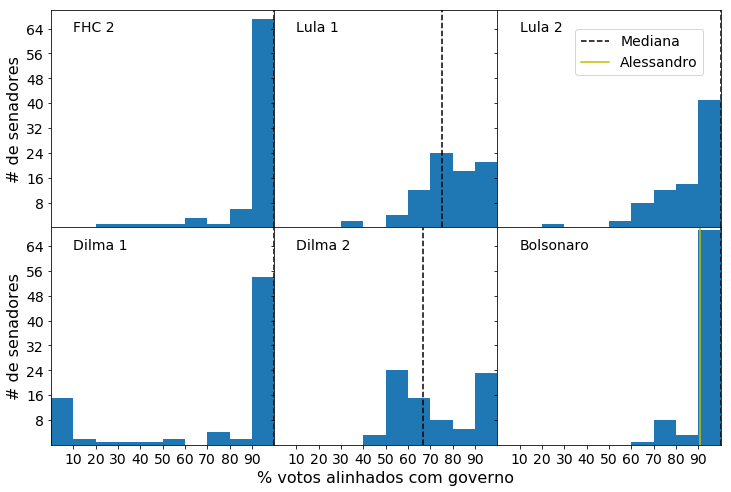

In [210]:
legList = sorted(v.legislatura.unique())[1:]
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(12,8))
nRows = 2
nCols = 3

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.1,0.9,LegName[i],transform = pl.gca().transAxes, fontsize=14)
    # Formatação do eixo x:
    pl.xlim([0,100])
    pl.gca().xaxis.set_major_locator(MaxNLocator(prune='both'))
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        if (i==4): 
            pl.xlabel(u'% votos alinhados com governo', fontsize=16)
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de senadores', fontsize=16)
    # Plot:    
    median = senDistPlot(legList[i])
    pl.axvline(median,linestyle='--',color='k')
    # Coloca acredito:
    if legList[i]==56:
        pl.axvline(apoioAlex, color='y')
    pl.gca().tick_params(labelsize=14)
    pl.gca().yaxis.set_major_locator(MaxNLocator(prune='both'))
    # Coloca legenda:
    if (i==2):
        import matplotlib.colors as colors 
        vertical_lines = [lines.Line2D([], [], color='k', linestyle='--', label='Mediana'),
                          lines.Line2D([], [], color='y', linestyle='-', label='Alessandro')]
        pl.legend(handles=vertical_lines, fontsize=14, loc=(0.35,0.7))
    
pl.subplots_adjust(hspace=0,wspace=0)
#xu.saveFigWdate('graficos/senado/apoio_ao_governo_senadores.pdf')
#pl.show()

In [228]:
# Cria tabela de alinhamento dos deputados:

NvotosSen = grbySen.size()
NvotosSen.name = '# votos c/ orient.'

tab_alinhamento_governo = orientGovAtual.sort_values('num_votacao')[['id_senador', 'nome_senador', 'partido_senador']]\
.drop_duplicates(subset='id_senador', keep='last').set_index('id_senador', drop=True)\
.join(NvotosSen, how='outer').join(grbySen.apoio.mean(), how='outer').sort_values(['partido_senador', 'nome_senador'])

tab_alinhamento_governo['apoio'] = np.round(tab_alinhamento_governo.apoio*100,1)

tab_alinhamento_governo.rename(axis='columns', inplace=True,
                               mapper={'nome_senador':'Nome', 'partido_senador':'Partido', 'apoio':'Alinhamento'})

tab_alinhamento_governo.to_latex('../relatorios/tab-alinhamento-governo-senadores.tex',
                                 index=False, encoding='utf8', longtable=True, decimal=',')

In [229]:
tab_alinhamento_governo

,Nome,Partido,# votos c/ orient.,Alinhamento
id_senador,,,,
5982,Alessandro Vieira,Cidadania,11,90.9
5718,Eliziane Gama,Cidadania,12,100.0
5942,Marcos do Val,Cidadania,11,90.9
470,Chico Rodrigues,DEM,8,100.0
4531,Jayme Campos,DEM,10,100.0
5422,Marcos Rogério,DEM,8,100.0
1023,Maria do Carmo Alves,DEM,4,100.0
5732,Rodrigo Pacheco,DEM,11,100.0
475,Confúcio Moura,MDB,12,100.0


In [297]:
# Adiciona alinhamento ao partido na tabela:
Norient_by_deputado = grbyDepP.apoio.size()
Norient_by_deputado.name = 'norient'

tab_alinhamento_final = tab_alinhamento_governo\
.join(Norient_by_deputado)\
.join(np.round(grbyDepP.apoio.mean()*100,1))\
.rename(axis='columns', mapper={'apoio':'Al. part.'})
tab_alinhamento_final['norient'].fillna(0, inplace=True)
tab_alinhamento_final['norient'] = tab_alinhamento_final['norient'].astype(int)
tab_alinhamento_final.rename(axis='columns', mapper={'norient':u'# Or. part.'}, inplace=True)

### Análise por votação

In [127]:
xu.unique(v.tipoMateria)

11: DEN | MPV | PDS | PEC | PL | PLC | PLP | PLS | PLV | PRS | SCD


In [169]:
# Conferindo que timestamp corresponde a uma única votação:
votosFavGovByDate = \
v.sort_values('num_votacao').groupby(['DataSessao','num_votacao'])['apoio'].sum()

In [171]:
v.DataSessao.max()

Timestamp('2019-05-07 00:00:00')

In [203]:
anoVotacao    = np.array([pd.to_datetime(x[0]).year for x in votosFavGovByDate.index.values])
votosIdx      = np.arange(len(anoVotacao))
votoByVotacao = pd.DataFrame({'ano':anoVotacao, 'nvotos':np.array(votosFavGovByDate)})
votoByVotacao = votoByVotacao.loc[votoByVotacao.ano>=1999]
grByAno       = votoByVotacao.groupby('ano')
nVotosMedio   = grByAno.mean().values

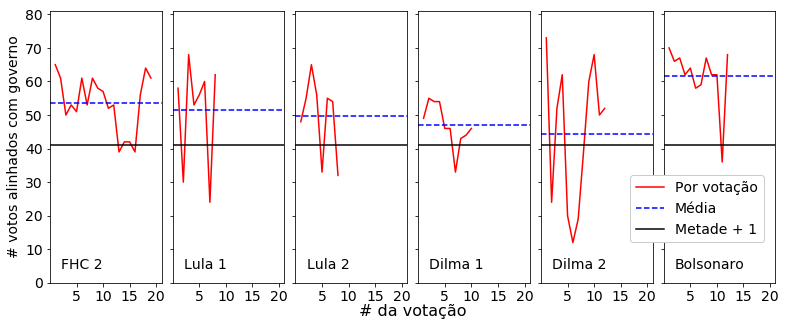

In [211]:
fig = pl.figure(figsize=(13,5))
anoUnique = votoByVotacao.ano.unique()
for i in range(len(anoUnique)):
    pl.subplot(1,len(anoUnique),i+1)
    # Text:
    pl.text(0.1,0.05, LegName[i], transform = pl.gca().transAxes, fontsize=14)
    # Plot:
    y = grByAno.get_group(anoUnique[i]).values
    x = np.arange(1,1+len(y))
    pl.plot(x,y,'r-')
    pl.axhline(81/2+1, color='k')
    pl.axhline(nVotosMedio[i], color='blue', linestyle='--')
    # Format y:
    pl.ylim([0,81])
    if i>0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel(u'# votos alinhados com governo', fontsize=14)
    pl.gca().tick_params(labelsize=14)
    pl.xticks([5,10,15,20])
    pl.xlim([0,21])
    
    # Label x comum:
    axComum = fig.add_subplot(111, frameon=False)
    pl.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    axComum.set_xlabel(u'# da votação', fontsize=16)
    
    # Legenda:
    vertical_lines = [lines.Line2D([], [], color='red', linestyle='-', label=u'Por votação'),
                      lines.Line2D([], [], color='blue', linestyle='--', label=u'Média'),
                      lines.Line2D([], [], color='k', linestyle='-', label='Metade + 1')]
    pl.legend(handles=vertical_lines, fontsize=14, loc=(0.8,0.15), framealpha=1)
    
pl.subplots_adjust(wspace=0.1)
#xu.saveFigWdate('graficos/senado/apoio_senado_ao_governo_por_votacao.pdf')
pl.show()

In [218]:
# Quantas vezes o governo orientou o voto na atual legislatura:
len(v.loc[(v.legislatura==56)]['num_votacao'].drop_duplicates())

12

In [298]:
# Exporta tabela:
tab_alinhamento_final.to_latex('../relatorios/tab-alinhamento-deputados.tex',
                                 index=False, encoding='utf8', longtable=True, decimal=',', na_rep='-')

513
515
523
526
527
486


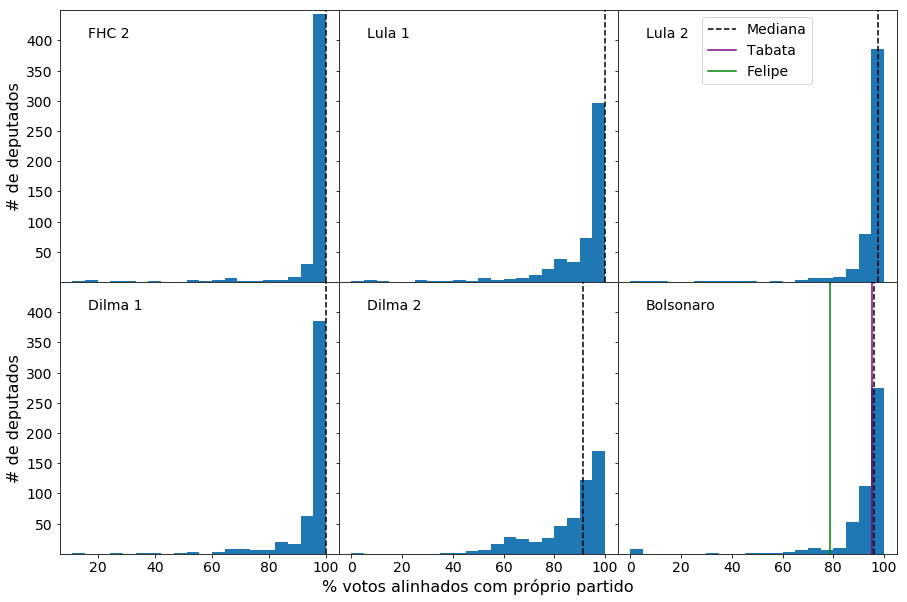

In [313]:
legList = sorted(v.legislatura.unique())
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(15,10))
nRows = 2
nCols = 3

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.1,0.9,LegName[i],transform = pl.gca().transAxes, fontsize=14)
    # Formatação do eixo x:
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        if (i==4):
            pl.xlabel(u'% votos alinhados com próprio partido', fontsize=16)
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de deputados', fontsize=16)
    # Plot:    
    median = depDistPlot(legList[i])
    pl.axvline(median,linestyle='--',color='k')
    # Coloca acredito:
    if legList[i]==56:
        pl.axvline(fidTabata, color='purple')
        pl.axvline(fidFelipe, color='g')
    pl.gca().tick_params(labelsize=14)
    pl.gca().yaxis.set_major_locator(MaxNLocator(prune='both'))
    # Coloca legenda:
    if (i==2):
        import matplotlib.colors as colors 
        vertical_lines = [lines.Line2D([], [], color='k', linestyle='--', label='Mediana'),
                          lines.Line2D([], [], color=colors.to_rgba('purple', alpha=None), linestyle='-', label='Tabata'),
                          lines.Line2D([], [], color='g', linestyle='-', label='Felipe')]
        pl.legend(handles=vertical_lines, fontsize=14, loc='upper center')

pl.subplots_adjust(hspace=0,wspace=0)
#xu.saveFigWdate('graficos/fidelidade_partidaria_deputados.pdf')
pl.show()

# Testes

In [64]:
# Deputados trocam de partido:

t = v.loc[v.legislatura==56].groupby('deputado')['partido_deputado']
print t.unique().loc[(t.nunique()>1)]

print v.loc[v.legislatura==56].deputado.nunique(), 
v.loc[v.legislatura==56].groupby('partido_deputado')['deputado'].nunique().sum()

deputado
109429              [PTC, PRB]
115746               [PHS, PR]
146788               [PHS, PP]
178863             [PPL, PROS]
204427               [PHS, PR]
204432    [PTC, Solidariedade]
204448           [DC, S.Part.]
204463              [PRP, PSD]
204510               [PHS, PP]
204517               [PMN, PR]
204550          [Patriota, PR]
204554               [PHS, PR]
204567               [PRP, PR]
Name: partido_deputado, dtype: object
517

530

# Lixo

In [24]:
# Tamanho das bancadas:
query = 'SELECT * FROM `gabinete-compartilhado.analise_congresso_poder.camara_sigla_numero_membros_tab`'
partido_size = pd.read_gbq(query, project_id='gabinete-compartilhado', 
                dialect='standard',
                private_key='../keys-configs/gabinete-compartilhado.json')

temp = pd.DataFrame()
temp['atuais'] = pd.Series(partidosAtuais, name='atuais')
partido_size.merge(temp, left_on='sigla_nova', right_on='atuais', how='outer')

,nome,sigla_nova,total_membros,atuais
0,Partido Republicano Progressista,PRP,1.0,PRP
1,Partido Humanista da Solidariedade,PHS,1.0,PHS
2,Rede Sustentabilidade,REDE,1.0,REDE
3,Partido da Mobilização Nacional,PMN,2.0,PMN
4,Partido Verde,PV,4.0,PV
5,Patriota,Patriota,4.0,Patriota
6,Avante,Avante,7.0,Avante
7,Cidadania,Cidadania,8.0,Cidadania
8,Partido Social Cristão,PSC,8.0,PSC
9,Partido Comunista do Brasil,PCdoB,8.0,PCdoB


In [ ]:
print xu.unique(v.partido_orientacao)
print xu.unique(v.legislatura)
print xu.freq(v.voto,'Obstrução'), xu.freq(v.orientacao,'Obstrução')
print xu.freq(v.voto,'Sim'), xu.freq(v.orientacao,'Sim')
print xu.freq(v.voto,'Não'), xu.freq(v.orientacao,'Não')

In [ ]:
listaLegislatura = sorted(v.legislatura.unique())
anoLegislatura   = 2019 - 4*(56-np.array(listaLegislatura))

def histApoio(mandante, partido=None):
    return np.array([freqApoio(l, mandante, partido) for l in listaLegislatura])

In [ ]:
def histBarPlot(mandante, partido=None):
    x = np.arange(1,1+len(anoLegislatura))
    y = 100*histApoio(mandante,partido)
    pl.bar(x,y)
    pl.xticks(x, anoLegislatura)
    pl.xlabel('Ano')
    pl.ylabel('% de apoio')
    if partido==None:
        pl.title(mandante+' orienta geral')
    else:
        pl.title(mandante+' orienta '+partido)
    pl.ylim([0,105])

In [ ]:
pl.figure(figsize=(6*2.5,6*2.5))
for n in range(36):
    pl.subplot(6,6,n+1)
    histBarPlot('Governo', sorted(v.partido_deputado.unique())[1+n])
pl.tight_layout()
pl.show()

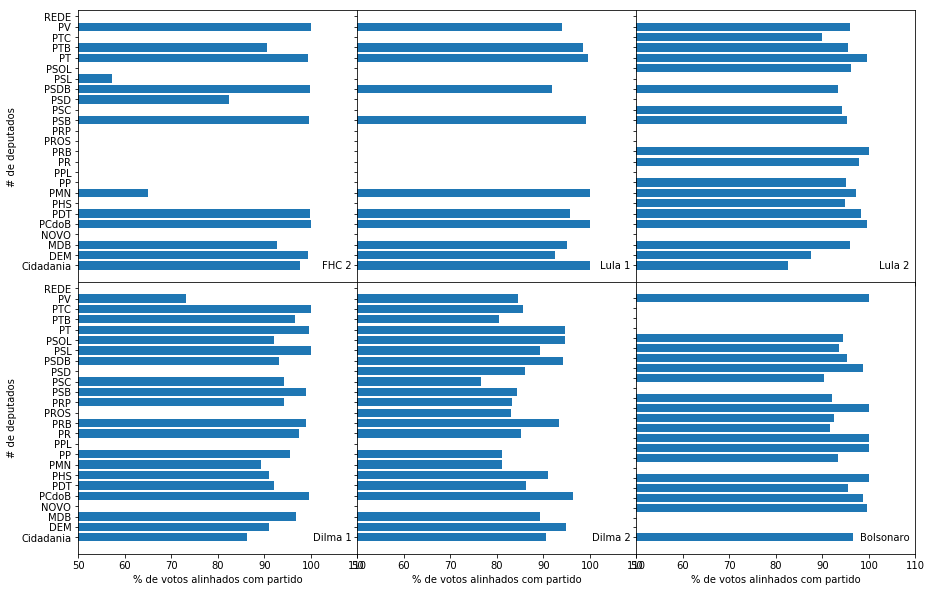

In [205]:
legList = sorted(v.legislatura.unique())
LegName = ['FHC 2','Lula 1','Lula 2','Dilma 1','Dilma 2','Bolsonaro']
pl.figure(figsize=(15,10))
nRows = 2
nCols = 3


x = np.arange(1,len(partidosAtuais))
apoioMin = int(coesaoByLegPartido.apoio.min()*10)*10

for i in range(len(legList)):
    pl.subplot(nRows,nCols,i+1)
    # Texto:
    pl.text(0.98,0.05,LegName[i],transform = pl.gca().transAxes, ha='right')
    # Formatação do eixo x:
    if i < nCols*(nRows-1):
        pl.gca().tick_params(labelbottom=False)
    else:
        pl.xlabel('% de votos alinhados com governo')
    # Formatação do eixo y:
    if i%nCols!=0:
        pl.gca().tick_params(labelleft=False)
    else:
        pl.ylabel('# de deputados')
    # Plot:
    pl.barh(x,100*pivotCoesao[legList[i]].values)
    pl.yticks(x,pivotCoesao[legList[i]].index.values)
    pl.xlabel('% de votos alinhados com partido')
    pl.xlim([apoioMin,110])
    # Coloca acredito:
    #if legList[i]==56:
    
    
pl.subplots_adjust(hspace=0,wspace=0)
pl.show()